In [2]:
import numpy as np
from astropy.io import fits
from astropy.convolution import convolve
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
plt.style.use(astropy_mpl_style)

In [2]:
def HMS2deg(ra='', dec=''):
    RA, DEC, rs, ds = '', '', 1, 1
    if dec:
        D, M, S = [float(i) for i in dec.split()]
        if str(D)[0] == '-':
            ds, D = -1, abs(D)
        deg = D + (M/60) + (S/3600)
        DEC = '{0}'.format(deg*ds)
            
    if ra:
        H, M, S = [float(i) for i in ra.split()]
        if str(H)[0] == '-':
            rs, H = -1, abs(H)
        deg = (H*15) + (M/4) + (S/240)
        RA = '{0}'.format(deg*rs)
        
    if ra and dec:
        return (float(RA), float(DEC))
    else:
        return float(RA) or float(DEC)

In [3]:
ra, dec = HMS2deg(ra='2 52 45.210', dec='+0 39 58.36')

In [4]:
with fits.open('MAST_2021-10-30T1757/MAST_2021-10-30T1757/HST/j9op04010/j9op04010_drc.fits') as hdu:
    wcs = WCS(fobj=hdu[1], header=hdu[1].header)

x, y = wcs.all_world2pix(ra, dec, 1, adaptive=False, ra_dec_order=True)
 
# Print results
print('Pixel ({}, {}) converts to RA: {}, Dec:{}'.format(x, y, ra, dec))

Pixel (2193.8868504919265, 3179.163994403627) converts to RA: 43.188375, Dec:0.6662111111111111


In [8]:
class data_reduction(object):
    '''
    Class data_reduction gives the final fits file after centering, cropping and finally convolving
    '''
    
    def __init__(self, filepath='filepath', filename='filename', RA='', DEC=''):
        '''
        runs when the class is called
        
        Inputs
        filepath: /path/to/file/
        filename: name of file
        ra: Right ascension of object of interest
        dec: declination of object of interest
        '''
        
        print('Reading the fits file.')
        
        self.filepath=filepath
        self.filename=filename
        
        self.hdul=fits.open(self.filepath+self.filename)
            #self.hdul.verify('fix')
            
        #Choosing the data header, usually header[1]
        self.data = self.hdul[1].data
            
        #World co-ordinates of image
        self.wcs = WCS(fobj=self.hdul[1], header=self.hdul[1].header)
            
        #Weight and context of image
        self.weight = self.hdul[2].data
        self.context = self.hdul[3].data
            
        self.ra = RA
        self.dec = DEC
            
        print('Input RA:', self.ra, 'Input DEC:', self.dec)
            
    def HMS2deg(self, ra='', dec=''):
        '''
        Function converts RA and DEC of object to degrees
        
        Inputs
        ra: Right ascension of object of interest
        dec: declination of object of interest
        
        Outputs
        RA: Right Ascension in degrees
        DEC: Declination in degrees
        '''
        RA, DEC, rs, ds = '', '', 1, 1
        if dec:
            D, M, S = [float(i) for i in dec.split()]
            if str(D)[0] == '-':
                ds, D = -1, abs(D)
            deg = D + (M/60) + (S/3600)
            DEC = '{0}'.format(deg*ds)
        
        if ra:
            H, M, S = [float(i) for i in ra.split()]
            if str(H)[0] == '-':
                rs, H = -1, abs(H)
            deg = (H*15) + (M/4) + (S/240)
            RA = '{0}'.format(deg*rs)
        #TODO: RA with value greater than 180 degrees should be subtracted by 360.(check)
        
        if ra and dec:
            return (float(RA), float(DEC))
        else:
            return float(RA) or float(DEC) 
    
    def center(self):
        '''
        Function to find the centre of the image
        
        Outputs
        x_center: pixel x coordinate of centre of object of interst
        y_center: pixel y coordinate of centre of object of interst
        '''
        
        #updates ra and dec
        self.ra, self.dec = self.HMS2deg(ra=self.ra, dec=self.dec)
        print('New RA in degrees:', self.ra, 'New DEC in degrees:',self.dec)
        
        #Center coordinates of the object of interest
        x_center, y_center = self.wcs.all_world2pix(self.ra, self.dec, 1, adaptive=False, ra_dec_order=True)
        
        print('Center coords:', x_center, y_center)
        
        return x_center, y_center
    
    def crop(self, cropsize=74):
        '''
        Function to crop the data
        
        Input
        cropsize: The size of a single axis, delfault value is 74 (This value is chosen because the PSF has 74x74 dimensions)
        outfilepath: /path/to/save/outfile/in/
        
        Output
        Creates an output .fits file
        '''
        
        self.xc, self.yc = self.center()
        
        #Indices of array can only be integers, Brfore converting float to int, round the decimal to the closest value
        xc = int(np.round(self.xc))
        yc = int(np.round(self.yc))
        cs = int(np.round(cropsize/2))
        print('Rounded pixel coord center values:', xc, yc)
        
        #Defining boundaries of pixel coords of the image
        x1 = xc-cs
        x2 = xc+cs
        
        y1 = yc-cs
        y2 = yc+cs
        
        self.hdul[1].data=self.data[y1:y2,x1:x2]
        #cropping weight and context to reduce filesize
        self.hdul[2].data=self.weight[y1:y2,x1:x2]
        self.hdul[3].data=self.context[y1:y2,x1:x2]
        
        return
    
    def convolve(self, psffile='psffile'):
        '''
        Function convolves the HST image with PSF
        
        Inputs
        psffile: /path/to/psffile/psffilename
        '''
        
        self.image_data = self.hdul[1].data
        
        with fits.open(psffile) as self.psf_hdul:
            #data for psf in header[0]
            self.psf_data = self.psf_hdul[0].data
            
        #kernel should be odd for convolution
        self.convolved_data=convolve(self.image_data[0:73, 0:73], self.psf_data[0:73, 0:73])

        return
    
    def writefile(self, outfilepath='outfilepath'):
        '''
        Function writes to the fits file
        '''
        
        self.convolve_ImageHDU = fits.ImageHDU(name='CONVOLVE', data=self.convolved_data)
        self.hdul.append(self.convolve_ImageHDU)
        
        self.hdul.writeto(outfilepath + self.filename + '_cropped_convolved.fits',overwrite=True)
        
        self.hdul.close()
        return
    
    def plot_images(self, cropped_image=True, psf=True, convolve=True):
        '''
        plot images
        '''
        
        if cropped_image == True:
            plt.figure()
            plt.imshow(self.hdul[1].data, cmap='gray', norm=LogNorm())
            plt.colorbar()
            plt.show()
        else:
            print('Plotting cropped image is turned off')
            
        if psf == True:
            plt.figure()
            plt.imshow(self.psf_data, cmap='gray', norm=LogNorm())
            plt.colorbar()
            plt.show()
        else:
            print('Plotting PSF is turned off')
            
        if convolve == True:
            plt.figure()
            plt.imshow(self.convolved_data, cmap='gray', norm=LogNorm())
            plt.colorbar()
            plt.show()
        else:
            print('Plotting convolved image is turned off')
            
        return

In [13]:
a=data_reduction(filepath='MAST_2021-10-30T1757/MAST_2021-10-30T1757/HST/j9op04010/', filename='j9op04010_drc.fits', RA='2 52 45.216', DEC='+0 39 58.36')

Reading the fits file.
Input RA: 2 52 45.216 Input DEC: +0 39 58.36


In [14]:
a.crop()

New RA in degrees: 43.1884 New DEC in degrees: 0.6662111111111111
Center coords: 2193.4164836395603 3177.4266638610256
Rounded pixel coord center values: 2193 3177


In [6]:
a.convolve(psffile='../../galaxies_software/tinytim/SLACS100.fits')

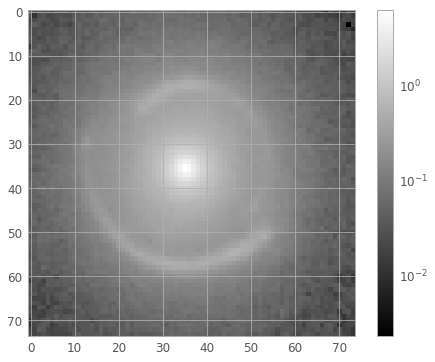

Plotting PSF is turned off
Plotting convolved image is turned off


In [7]:
a.plot_images(psf=False, convolve=False)

In [20]:
a.writefile(outfilepath='./')

In [21]:
hdul = fits.open('j9op04010_drc.fits_cropped_convolved.fits')

In [22]:
hdul.info()

Filename: j9op04010_drc.fits_cropped_convolved.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     849   ()      
  1  SCI           1 ImageHDU        93   (74, 74)   float32   
  2  WHT           1 ImageHDU        44   (74, 74)   float32   
  3  CTX           1 ImageHDU        37   (74, 74)   int32   
  4  HDRTAB        1 BinTableHDU    633   8R x 312C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, K, 4A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 23A, D, D, D, D, K, K, K, 8A, K, 23A, 9A, 20A, K, 4A, K, K, K, K, K, K, 23A, D, D, D, D, K, K, 3A, 3A, 4A, 4A, L, D, D, D, 3A, 1A, K, D, D, D, 13A, 3A, 4A, 4A, 12A, 12A, 23A, 8A, 23A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 23A, D, K, D, 6A, 9A, 8A, D, D, L, 4A, 18A, 3A, K, 7A, 5A, 3A, D, 13A, 8A, 4A, 3A, L, K, L, K, L, K, K, D, D, D, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, 23A, L, 1A, 3A, 1A, D, 3A, 6A, K, D, D, D, D, D, D, D, D, D, D, 23A, D, D, D, D, 

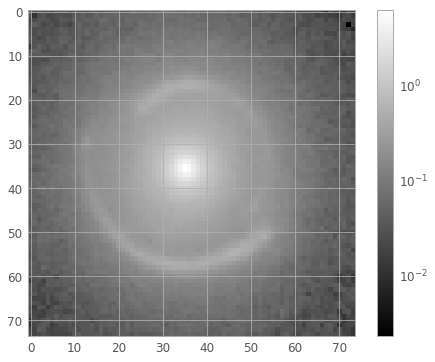

In [23]:
plt.figure()
plt.imshow(hdul[1].data, cmap='gray', norm=LogNorm())
plt.colorbar()
plt.show()

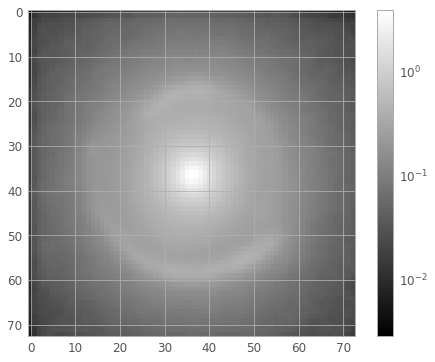

In [24]:
plt.figure()
plt.imshow(hdul[5].data, cmap='gray', norm=LogNorm())
plt.colorbar()
plt.show()

In [15]:
2047 - (2*2047 - 3177)

1130